In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from cohirf.experiment.hpo_csv_clustering_experiment import HPOCSVClusteringExperiment
from cohirf.experiment.hpo_custom_clustering_experiment import HPOCustomClusteringExperiment
from IPython.display import clear_output
import seaborn as sns
import plotly.express as px

In [2]:
def generate_3d_clustered_data(seed=42, distance=10, std=1, standardize=False):
    rng = np.random.default_rng(seed)
    # get two random numbers between 0 and 1 to be the mean centers of the clusters 
    mean1, mean2 = rng.random(2)
    # get the third mean to satisfy the distance requirement between clusters
    centers = [[mean1, mean2, distance],
            [mean1, mean2, 0],
            [mean1, mean2, -distance]]
    centers = np.array(centers)
    cov = np.eye(3) * std**2
    X = []
    y = []
    for i, center in enumerate(centers):
        samples = rng.multivariate_normal(center, cov, size=100)
        X.append(samples)
        y += [i] * 100
    X = np.vstack(X)
    y = np.array(y)
    # shuffle the dataset
    indices = rng.permutation(len(X))
    X = X[indices]
    y = y[indices]
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y, centers

In [3]:
def _generate_simplex_vertices(n_clusters, n_features, distance, seed):
    # Step 1: create a simplex in R^(n_clusters-1) using orthonormalized Gram matrix
    # Start with identity and subtract the centroid projection

    if n_clusters > n_features + 1:
        raise ValueError("Impossible configuration: need n_clusters ≤ n_features+1 for equal pairwise distances.")

    A = np.eye(n_clusters) - np.ones((n_clusters, n_clusters)) / n_clusters

    # Step 2: take first n_features columns (or all if n_clusters-1 == n_features)
    # And do eigen-decomposition to get embedding
    vals, vecs = np.linalg.eigh(A)
    coords = vecs[:, 1:n_clusters] * np.sqrt(vals[1:n_clusters])

    # coords is n_clusters × (n_clusters-1). Embed into R^n_features by padding with zeros if needed.
    if n_features > n_clusters - 1:
        coords = np.pad(coords, ((0, 0), (0, n_features - (n_clusters - 1))))
    # Step 3: scale so that pairwise distances are exactly d
    # Current simplex has distance sqrt(2)
    coords *= distance / np.sqrt(2)

    # Step 4: random rotation in R^n_features
    rng = np.random.default_rng(seed)
    random_matrix = rng.normal(size=(n_features, n_features))
    Q, R = np.linalg.qr(random_matrix)
    coords = coords @ Q

    return coords

def generate_simplex_data(
    n_clusters: int = 3,
    n_features: int = 3,
    n_shared_features: int = 0,
    distance: float = 10.0,
    seed: int = 42,
    std: float | list[float] = 1.0,
    # cor: float | list[float] | None = None,
    standardize: bool = False,
    samples_per_cluster: int | list[int] = 100,
):
    """
    Generate n-dimensional clustered data with configurable parameters.

    Parameters:
    -----------
    n_clusters : int, default=3
        Number of clusters to generate
    n_features : int, default=3
        Total number of features/dimensions
    n_shared_features : int, default=2
        Number of features that are shared (same value) across all cluster centers
    distance : float, default=10
        Minimum pairwise distance between cluster centers in the non-shared dimensions
    seed : int, default=42
        Random seed for reproducibility
    std : float, default=1
        Standard deviation for the multivariate normal distribution
    standardize : bool, default=False
        Whether to standardize the data
    samples_per_cluster : int, default=100
        Number of samples per cluster

    Returns:
    --------
    X : ndarray of shape (n_clusters * samples_per_cluster, n_features)
        Feature matrix
    y : ndarray of shape (n_clusters * samples_per_cluster,)
        Labels
    centers : ndarray of shape (n_clusters, n_features)
        Cluster centers
    """
    rng = np.random.default_rng(seed)

    if n_shared_features >= n_features:
        raise ValueError("n_shared_features must be less than n_features")

    if n_clusters < 2:
        raise ValueError("n_clusters must be at least 2")

    # Generate shared coordinates (same for all clusters)
    shared_coords = rng.random(n_shared_features)

    n_varying_features = n_features - n_shared_features

    varying_centers = _generate_simplex_vertices(n_clusters, n_varying_features, distance, seed)

    # Combine shared and varying coordinates
    centers = []
    for varying_coords in varying_centers:
        center = np.concatenate([shared_coords, varying_coords])
        centers.append(center)

    centers = np.array(centers)

    # Generate covariance matrix
    if isinstance(std, list):
        if len(std) != n_features:
            raise ValueError("Length of std list must match n_features")
        cov = np.diag(np.array(std)**2)
    else:
        cov = np.eye(n_features) * std**2

    # Generate samples
    X = []
    y = []
    if isinstance(samples_per_cluster, list):
        if len(samples_per_cluster) != n_clusters:
            raise ValueError("Length of samples_per_cluster list must match n_clusters")
        
    for i, center in enumerate(centers):
        if isinstance(samples_per_cluster, list):
            samples_per_cluster_i = samples_per_cluster[i]
        else:
            samples_per_cluster_i = samples_per_cluster
        samples = rng.multivariate_normal(center, cov, size=samples_per_cluster_i)
        X.append(samples)
        y += [i] * samples_per_cluster_i

    X = np.vstack(X)
    y = np.array(y)

    # Shuffle the dataset
    indices = rng.permutation(len(X))
    X = X[indices]
    y = y[indices]

    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y, centers

In [4]:
# Interactive 3D scatter plot with Plotly
seed = 42
distance = 10
std = 5
standardize = False
X, y, centers = generate_3d_clustered_data(distance=distance, seed=seed, std=std, standardize=standardize)
# X = (X - X.mean(axis=0)) / X.std(axis=0)
# Use the same data from the previous cell
fig = px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=y.astype(str),
    title="Interactive 3D Scatter Plot of Synthetic Data",
    labels={"x": "X-axis", "y": "Y-axis", "z": "Z-axis", "color": "Class"},
)

# Customize the layout
fig.update_layout(scene=dict(xaxis_title="X-axis", yaxis_title="Y-axis", zaxis_title="Z-axis"), width=800, height=600)

# Show the interactive plot
fig.show()

In [5]:
# Interactive 3D scatter plot with Plotly
distance = 10
n_clusters = 3
n_features = 3
n_shared_features = 0
n_high_noise_features = 1
samples_per_cluster = 100
standardize = True
seed = 2
std = [1, 1, 100]
X, y, centers = generate_simplex_data(
    n_clusters=n_clusters,
    n_features=n_features,
    n_shared_features=n_shared_features,
    distance=distance,
    seed=seed,
    std=std,
    standardize=standardize,
    samples_per_cluster=samples_per_cluster,
)
# X = (X - X.mean(axis=0)) / X.std(axis=0)
# Use the same data from the previous cell
fig = px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=y.astype(str),
    title="Interactive 3D Scatter Plot of Synthetic Data",
    labels={"x": "X-axis", "y": "Y-axis", "z": "Z-axis", "color": "Class"},
)

# Customize the layout
fig.update_layout(scene=dict(xaxis_title="X-axis", yaxis_title="Y-axis", zaxis_title="Z-axis"), width=800, height=600)

# Show the interactive plot
fig.show()

# 3D evenly spaced data

In [30]:
# run experiment with KMeans and 3D data
seeds = [i for i in range(3)]
stds = [1, 2, 3, 5]
metric = "adjusted_rand"
direction = "maximize"
distance = 10
standardize = False
results = []
model = "KMeans"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_3d_clustered_data(seed=seed, std=std, distance=distance, standardize=standardize)
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        X.to_csv(data_dir / "X.csv", index=True)
        y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCSVClusteringExperiment(
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

In [29]:
all_results = pd.DataFrame(results)

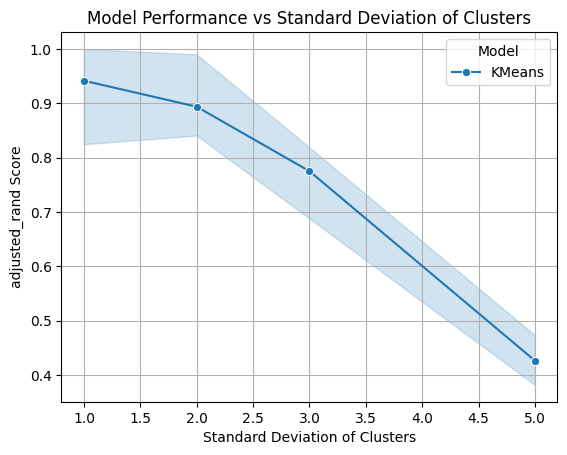

In [32]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=results, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [27]:
# run experiment with CoHiRF and 3D data
seeds = [i for i in range(3)]
stds = [1, 2, 3, 5]
metric = "adjusted_rand"
direction = "maximize"
distance = 10
standardize = False
results = []
model = "CoHiRF"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_3d_clustered_data(seed=seed, std=std, distance=distance, standardize=standardize)
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        X.to_csv(data_dir / "X.csv", index=True)
        y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCSVClusteringExperiment(
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
all_results = pd.concat([all_results, results], ignore_index=True)

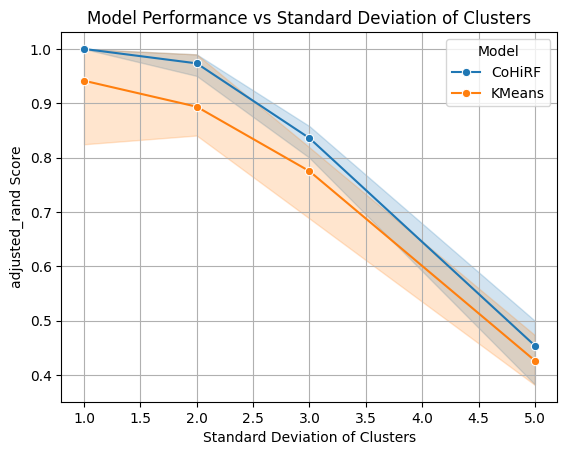

In [33]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=all_results, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [34]:
# run experiment with CoHiRF-top-down and 3D data
seeds = [i for i in range(3)]
stds = [1, 2, 3, 5]
metric = "adjusted_rand"
direction = "maximize"
distance = 10
standardize = False
results = []
model = "CoHiRF-top-down"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_3d_clustered_data(seed=seed, std=std, distance=distance, standardize=standardize)
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        X.to_csv(data_dir / "X.csv", index=True)
        y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCSVClusteringExperiment(
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages

In [36]:
all_results = pd.concat([all_results, results], ignore_index=True) 

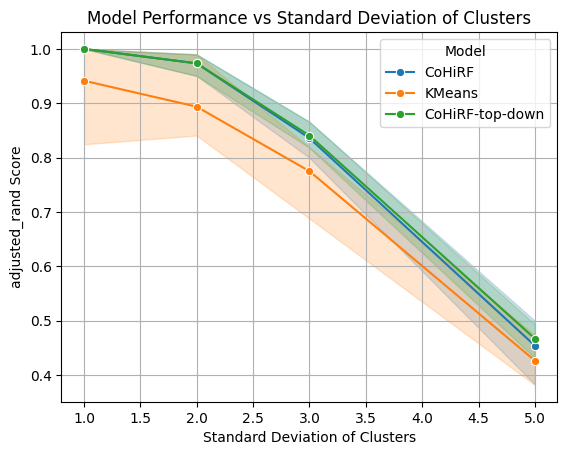

In [37]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=all_results, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()

# 3 clusters in 6D with 3 shared features

In [6]:
seeds = [i for i in range(3)]
stds = [1, 2, 3, 5]
metric = "adjusted_rand"
direction = "maximize"
distance = 10
n_clusters = 5
n_features = 10
n_shared_features = 0
samples_per_cluster = 100
n_high_noise_features = 1
standardize = True

In [9]:
# run experiment with KMeans
results = []
model = "KMeans"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_simplex_data(
            n_clusters=n_clusters,
            n_features=n_features,
            n_shared_features=n_shared_features,
            distance=distance,
            seed=seed,
            std=std,
            standardize=standardize,
            samples_per_cluster=samples_per_cluster,
        )
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        # X.to_csv(data_dir / "X.csv", index=True)
        # y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCustomClusteringExperiment(
            X=X,
            y=y,
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
all_results_2 = pd.DataFrame(results)

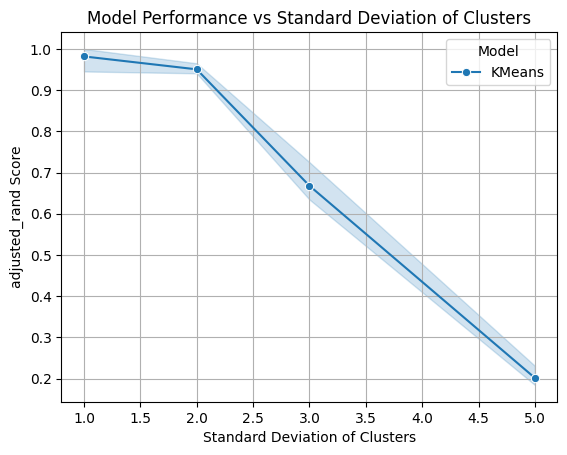

In [11]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=all_results_2, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [105]:
# run experiment with CoHiRF
results = []
model = "CoHiRF"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_simplex_data(
            n_clusters=n_clusters,
            n_features=n_features,
            n_shared_features=n_shared_features,
            distance=distance,
            seed=seed,
            std=std,
            standardize=standardize,
            samples_per_cluster=samples_per_cluster,
            n_high_noise_features=n_high_noise_features,
        )
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        X.to_csv(data_dir / "X.csv", index=True)
        y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCSVClusteringExperiment(
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/code/cohirf/cohirf/experiment/clustering_experiment.py:27: UserWarning:

Too many clusters (484) for dataset with 500 samples. Skipping metric calculation. If you want to calculate metrics anyway, set `calculate_metrics_even_if_too_many_clusters` to True.

/home/belucci/code/ml_experiments/ml_experiments/tuners.py:233: UserWarning:

metric adjusted_rand not found in dict returned by training_fn, available metrics are dict_keys(['n_clusters_', 'elapsed_time', 'seed_model'])



In [106]:
all_results_2 = pd.concat([all_results_2, results], ignore_index=True)

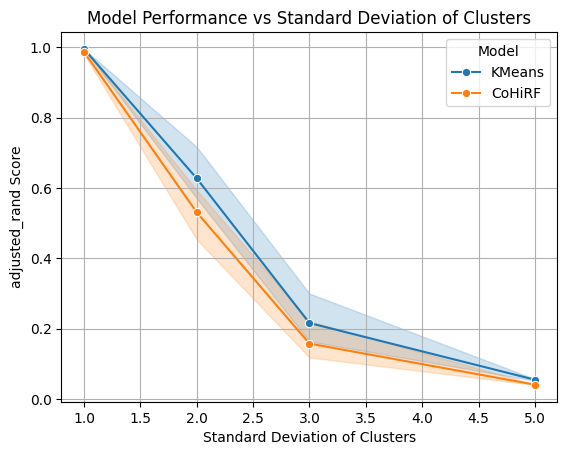

In [107]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=all_results_2, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [115]:
# run experiment with CoHiRF-top-down
results = []
model = "CoHiRF-top-down"
for seed in seeds:
    for std in stds:
        print(f"Running experiment with seed={seed}, std={std}")
        X, y, centers = generate_simplex_data(
            n_clusters=n_clusters,
            n_features=n_features,
            n_shared_features=n_shared_features,
            distance=distance,
            seed=seed,
            std=std,
            standardize=standardize,
            samples_per_cluster=samples_per_cluster,
            n_high_noise_features=n_high_noise_features,
        )
        columns = [f"Feature_{i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=columns)
        y = pd.Series(y, name="Label")
        X.to_csv(data_dir / "X.csv", index=True)
        y.to_csv(data_dir / "y.csv", index=True)
        experiment = HPOCSVClusteringExperiment(
            model=model,
            dataset_name="synthetic_3d",
            standardize=False,
            seed_dataset_order=seed,
            hpo_metric=metric,
            direction=direction,
            hpo_seed=seed,
            n_trials=30,
            verbose=1,
            raise_on_error=True,
            n_jobs=5,
        )
        result = experiment.run(return_results=True)[0]
        score = result["evaluate_model_return"][f"best/{metric}"]
        hpo_time = result["fit_model_return"]["elapsed_time"]
        best_time = result["evaluate_model_return"]["best/elapsed_time"]
        results.append(dict(score=score, hpo_time=hpo_time, best_time=best_time, seed=seed, model=model, std=std))
        clear_output(wait=True)

results = pd.DataFrame.from_records(results)

Running experiment with seed=2, std=5


Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages

In [116]:
all_results_2 = pd.concat([all_results_2, results], ignore_index=True)

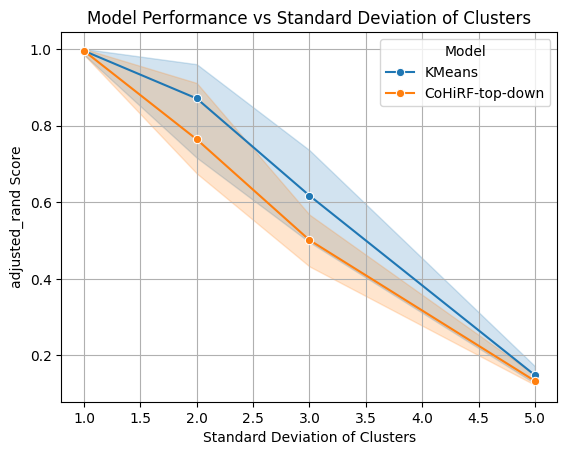

In [117]:
# plot results in a line plot (std vs score) using seaborn
sns.lineplot(data=all_results_2, x="std", y="score", hue="model", marker="o")
plt.title("Model Performance vs Standard Deviation of Clusters")
plt.xlabel("Standard Deviation of Clusters")
plt.ylabel(f"{metric} Score")
plt.legend(title="Model")
plt.grid(True)
plt.show()